In [1]:
%pip install pandas requests matplotlib

import pandas as pd
import requests
import matplotlib.pyplot as plt
from config import API_KEY


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Function to fetch data from Nasdaq API
def fetch_stock_data(symbol, api_key):
    url = f"https://data.nasdaq.com/api/v3/datasets/WIKI/{symbol}.json"
    params = {
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['dataset']['data'], columns=data['dataset']['column_names'])

# Fetch data for AT&T, T-Mobile, and Verizon
symbols = {
    'AT&T': 'T',
    'T-Mobile': 'TMUS',
    'Verizon': 'VZ'
}

stock_data = {}
for company, symbol in symbols.items():
    stock_data[company] = fetch_stock_data(symbol, API_KEY)

# Combine the data into a single DataFrame for analysis
combined_data = pd.concat(stock_data.values(), keys=stock_data.keys())
combined_data.reset_index(level=0, inplace=True)
combined_data.rename(columns={'level_0': 'Company'}, inplace=True)

# Save the combined data to a CSV file for further analysis
combined_data.to_csv('combined_data.csv', index=False)

# Display the combined data to verify
combined_data.head()

,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,AT&T,2018-03-27,34.85,35.2000,34.69,34.90,33198184.0,0.0,1.0,34.85,35.2000,34.69,34.90,33198184.0
1,AT&T,2018-03-26,35.06,35.2866,34.44,34.69,31281785.0,0.0,1.0,35.06,35.2866,34.44,34.69,31281785.0
2,AT&T,2018-03-23,35.37,35.9900,34.55,34.70,34260415.0,0.0,1.0,35.37,35.9900,34.55,34.70,34260415.0
3,AT&T,2018-03-22,35.95,36.0400,35.36,35.37,28063362.0,0.0,1.0,35.95,36.0400,35.36,35.37,28063362.0
4,AT&T,2018-03-21,36.34,36.5000,36.00,36.00,16776049.0,0.0,1.0,36.34,36.5000,36.00,36.00,16776049.0


In [3]:
# Convert the Date column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Sort the data by Company and Date
combined_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_data.fillna(method='ffill', inplace=True)
combined_data.fillna(method='bfill', inplace=True)

# Verify the cleaned data
combined_data.head()


C:\Users\Juanb\AppData\Local\Temp\ipykernel_11940\3598888710.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)
C:\Users\Juanb\AppData\Local\Temp\ipykernel_11940\3598888710.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='bfill', inplace=True)


,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
8491,AT&T,1984-07-19,59.75,59.87,59.38,59.38,77900.0,0.0,1.0,1.275248,1.277809,1.267351,1.267351,934800.0
8490,AT&T,1984-07-20,59.62,60.00,59.25,59.50,129800.0,0.0,1.0,1.272474,1.280584,1.264577,1.269913,1557600.0
8489,AT&T,1984-07-23,59.25,59.75,58.75,59.50,276100.0,0.0,1.0,1.264577,1.275248,1.253905,1.269913,3313200.0
8488,AT&T,1984-07-24,59.75,60.38,59.62,60.00,129100.0,0.0,1.0,1.275248,1.288694,1.272474,1.280584,1549200.0
8487,AT&T,1984-07-25,60.00,61.37,59.87,60.75,152400.0,0.0,1.0,1.280584,1.309824,1.277809,1.296591,1828800.0


In [20]:
# Filter the data to include only dates where all companies are in business

# Convert the Date column to datetime format and extract the year.
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data['Year'] = combined_data['Date'].dt.year

# Check the earliest date for each company
earliest_dates = combined_data.groupby('Company')['Date'].min()

# Find the latest earliest date among the companies
start_date = earliest_dates.max()
end_date = pd.Timestamp('2017-12-12')

# Filter the combined_data for the date range
filtered_data = combined_data[(combined_data['Date'] >= start_date) & (combined_data['Date'] <= end_date)]

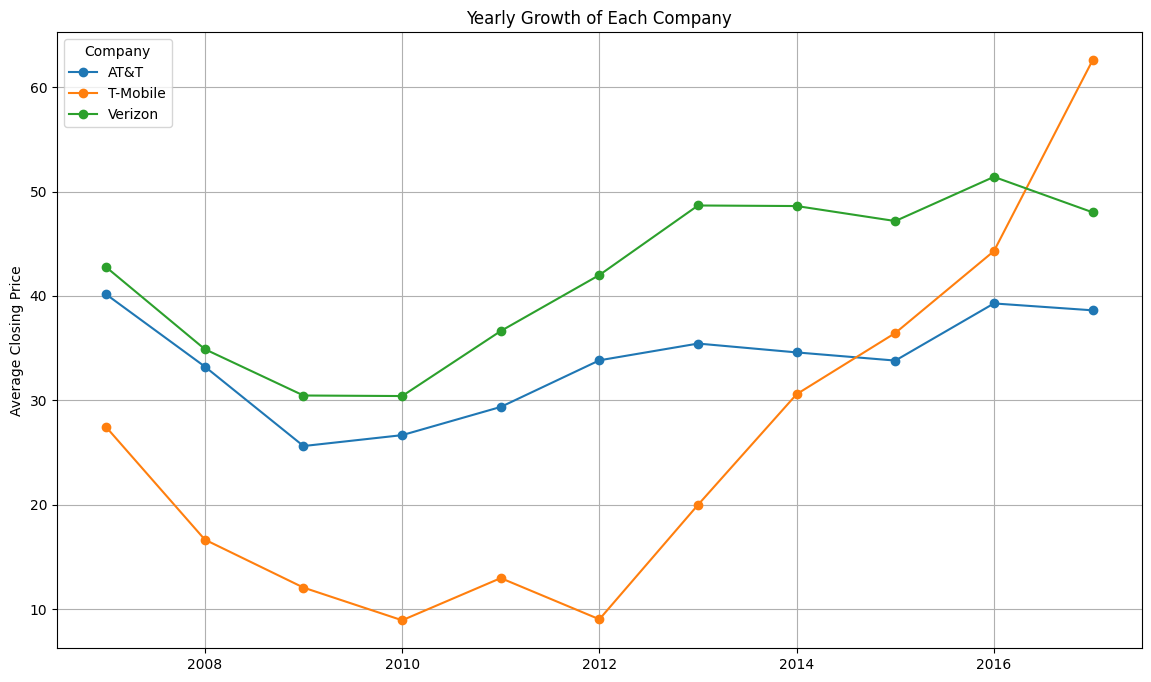

In [23]:
# Group by Year and Company and calculate the mean Close price
filtered_yearly_growth = filtered_data.groupby(['Year', 'Company'])['Close'].mean().unstack()

# Plot the data
plt.figure(figsize=(14, 8))
for Company in filtered_yearly_growth.columns:
    plt.plot(filtered_yearly_growth.index, filtered_yearly_growth[Company], marker='o', label=Company)

plt.title('Yearly Growth of Each Company')
plt.ylabel('Average Closing Price')
plt.legend(title='Company')
plt.grid(True)
plt.show()

C:\Users\Juanb\AppData\Local\Temp\ipykernel_11940\3257085433.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  percentage_change = filtered_data.groupby(['Company', 'Year']).apply(


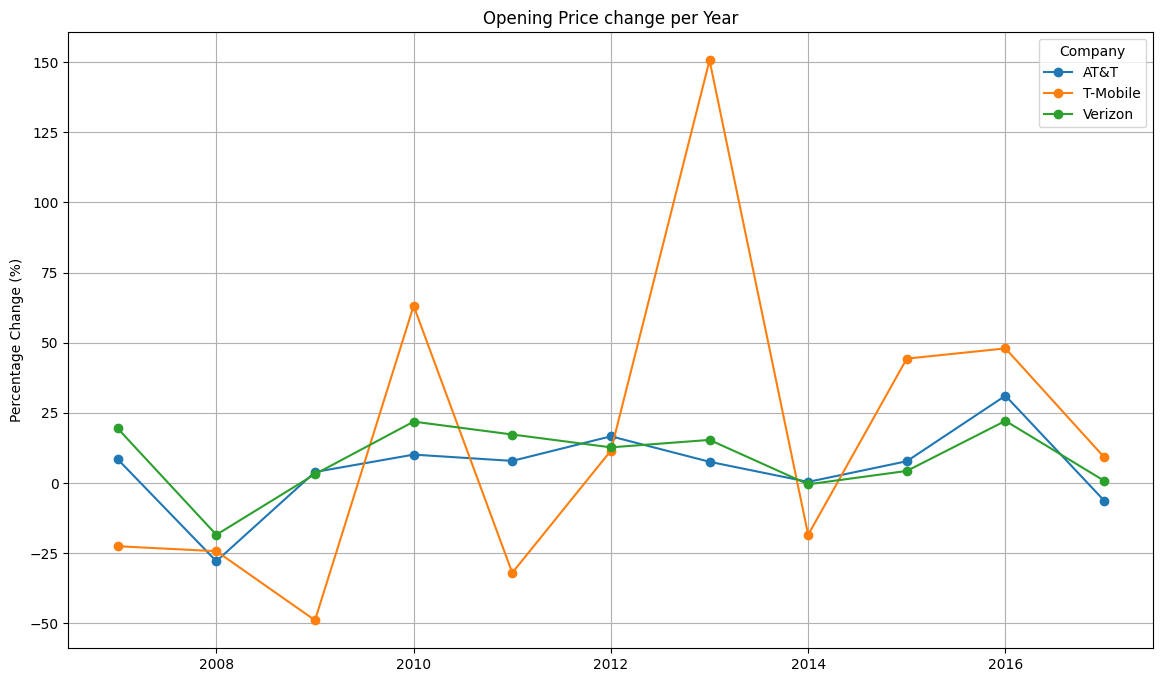

In [29]:
# Calculate the percentage change from the opening price at the beginning of the year to the closing price at the end of the year
percentage_change = filtered_data.groupby(['Company', 'Year']).apply(
    lambda x: (x.loc[x['Date'].idxmax()]['Adj. Close'] - x.loc[x['Date'].idxmin()]['Adj. Open']) / x.loc[x['Date'].idxmin()]['Adj. Open'] * 100
).reset_index(name='Percentage Change')

# Plot the percentage change
plt.figure(figsize=(14, 8))
for company in percentage_change['Company'].unique():
    company_data = percentage_change[percentage_change['Company'] == company]
    plt.plot(company_data['Year'], company_data['Percentage Change'], marker='o', label=company)

plt.title('Opening Price change per Year')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Company')
plt.grid(True)
plt.show()


C:\Users\Juanb\AppData\Local\Temp\ipykernel_11940\3337942375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Month'] = filtered_data['Date'].dt.to_period('M')


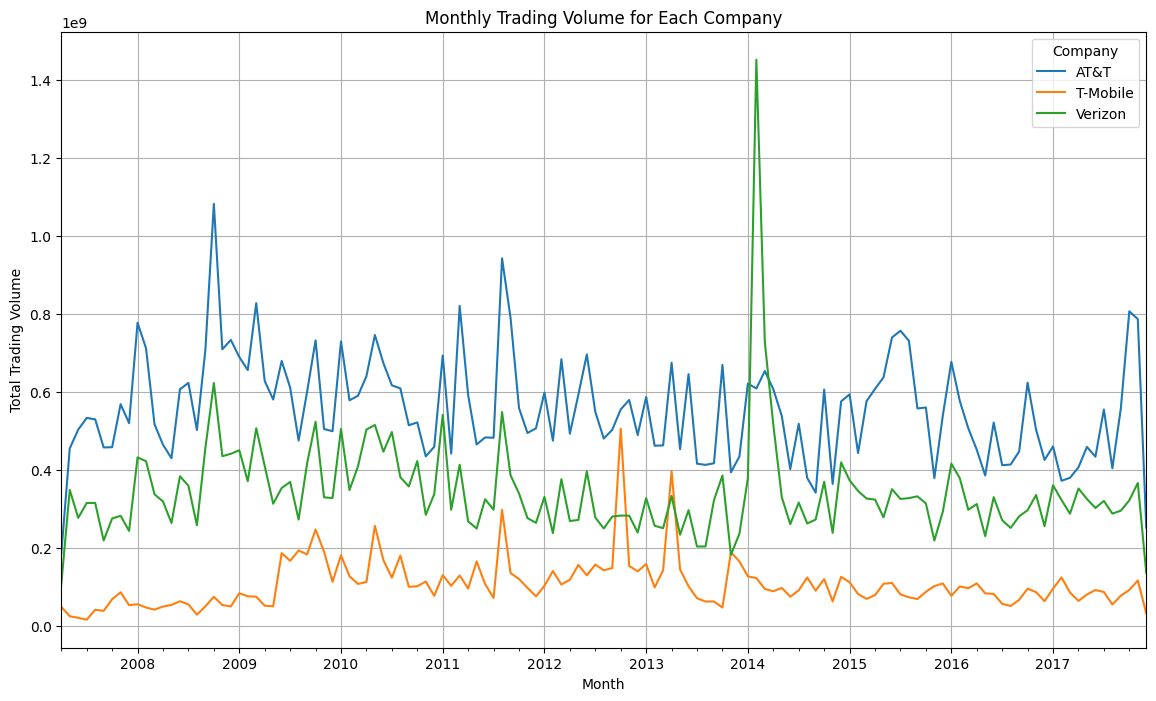

In [37]:
# Calculate the monthly trading volume
filtered_data['Month'] = filtered_data['Date'].dt.to_period('M')
monthly_volume = filtered_data.groupby(['Company', 'Month'])['Volume'].sum().unstack(level=0)

# Plot the monthly trading volume
monthly_volume.plot(figsize=(14, 8))
plt.title('Monthly Trading Volume for Each Company')
plt.xlabel('Month')
plt.ylabel('Total Trading Volume')
plt.legend(title='Company')
plt.grid(True)
plt.show()